# Cluster antibodies based on patterns of viral escape over time

## Import Python modules

In [1]:
import os
import glob
from collections import defaultdict
import pandas as pd

# Packages for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.colors as colors

# Packages for clustering 
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform, pdist, cdist
import numpy as np
import hdbscan

# Packages for umap
import umap

/home/hhaddox/miniconda3/envs/ncov-ab-escape2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## For each antibody, quantify how much the viral population has escaped that antibody in a sliding window over time

Read in estimated escape scores for each virus and antibody combination.

In [2]:
escape_scores_df = pd.read_csv('../data/ncov_escape_scores/all_predictions.csv')
escape_scores_df.rename(columns={'group':'ab_group'}, inplace=True)
escape_scores_df['escape_score'].clip(upper=1.0, inplace=True)
escape_scores_df.head()

/tmp/ipykernel_22932/3887360499.py:1: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  escape_scores_df = pd.read_csv('../data/ncov_escape_scores/all_predictions.csv')


,strain,all_aa_substitutions,measured_aa_substitutions,unmeasured_aa_substitutions,disallowed_aa_substitutions,n_disallowed_aa_substitutions,escape_score,antibody,ab_group,date,Nextstrain_clade,time
0,Wuhan-Hu-1/2019,NaN,NaN,NaN,NaN,0,0.0,BD55-6049,E3,2019-12-26,19A,0.008219
1,Wuhan-Hu-1/2019,NaN,NaN,NaN,NaN,0,0.0,BD56-965,B,2019-12-26,19A,0.008219
2,Wuhan-Hu-1/2019,NaN,NaN,NaN,NaN,0,0.0,XGv-318,F1,2019-12-26,19A,0.008219
3,Wuhan-Hu-1/2019,NaN,NaN,NaN,NaN,0,0.0,BD55-5687,E3,2019-12-26,19A,0.008219
4,Wuhan-Hu-1/2019,NaN,NaN,NaN,NaN,0,0.0,XGv-214,E2.1,2019-12-26,19A,0.008219


Quantify how much the viral population has escaped each antibody in a sliding window over time.

In [3]:
# Define parameters of sliding windows
start_time = 0
end_time = 3.5
window_width = 0.2
window_step_size = 0.1

# Make a list of sliding windows, recording the time corresponding to the left
# side of each window
left_side_of_window = 0
list_of_left_sides_of_windows = []
while left_side_of_window <= end_time:
    list_of_left_sides_of_windows.append(left_side_of_window)
    left_side_of_window = left_side_of_window + window_step_size

# For each antibody, record the average escape score of all viruses within each window
window_data = defaultdict(list)
dfs = []
for left_side_of_window in list_of_left_sides_of_windows:

    # Get the right side of the window
    right_side_of_window = left_side_of_window + window_width
       
    # Get data for all viruses in the window, and then compute their mean escape score
    # relative to each antibody
    data = (
        escape_scores_df[(escape_scores_df['time'].between(left_side_of_window, right_side_of_window))]
        .groupby(['antibody', 'ab_group'], as_index=False)['escape_score'].mean(numeric_only=True)
        .assign(time=left_side_of_window + window_width/2)
    ).copy()
    dfs.append(data)
           
escape_traj_df = pd.concat(dfs)
escape_traj_df.rename(columns={'escape_score' : 'mean_escape'}, inplace=True)

## Cluster antibodies based on escape trajectories computed above

Plot all antibody-escape trajectories.

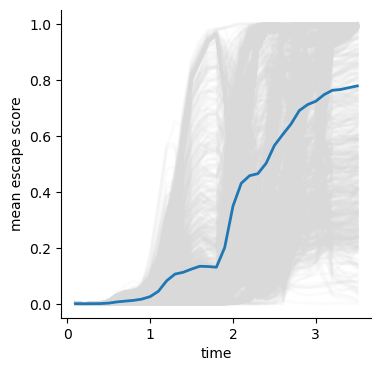

In [4]:
# Identify all antibodies for which the mean viral escape score surpasses 0.2 in at
# least one sliding window
max_escape = escape_traj_df.groupby('antibody')['mean_escape'].max()
abs_to_cluster = max_escape[max_escape > 0.2].index.values

#  Plot escape trajectories for all antibodies to cluster
data = escape_traj_df[escape_traj_df['antibody'].isin(abs_to_cluster)]
plt.figure(figsize=[4,4])
sns.lineplot(
    x='time', y='mean_escape', data=data,
    errorbar=None, linewidth=2, zorder=10
)
sns.lineplot(
    x="time", y="mean_escape", data=data,
    units='antibody', estimator=None, color=".85", linewidth=2, alpha=0.1
)
plt.ylabel('mean escape score')
sns.despine()
plt.show()

Below, we use UMAP to reduce the dimensionality of the data. Specifically, each antibody has an escape score in each window. Each of these scores can be thought of as a dimension, such that the data is N dimensional where N is the number of windows. We use UMAP to reduce the number of dimensions to two.

Then, we use k-means clustering to cluster the antibodies in the two-dimensional space. We set k = 20 to obtain fine-grained clusters. We then manually combine and tweak clusters, obtaining 9 total clusters.

In [5]:
# Fit the model to data 
data = escape_traj_df.copy()
data['time'] = data['time'].apply(lambda x: f'{x:.2f}')
escape_matrix = (
    data[data['antibody'].isin(abs_to_cluster)]
    .pivot_table(index='antibody', columns='time', values='mean_escape')
    .clip(upper=0.75)
)
umap_model = umap.UMAP(random_state=42)  # Using seed to get same results every time
embedding = umap_model.fit_transform(escape_matrix)
escape_matrix['umap_x'] = embedding[:, 0]
escape_matrix['umap_y'] = embedding[:, 1]

# Use k-means to cluster
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=0, max_iter = 8000).fit(escape_matrix[['umap_x', 'umap_y']])
escape_matrix['kmeans_cluster'] = kmeans.labels_#.astype(str)

# Refine the clusters from k-means
manual_clusters = {

    5 : 1,
    19 : 1,

    2 : 3,
    8 : 3,
    14 : 3,
    18 : 3,

    4 : 4,
    6 : 4,
    16 : 4,

    0 : 5,
    7 : 5,
    10 : 5,

    13 : 6,
    15 : 6,

    1 : 7,
    17 : 7,

    9 : 8,
    11 : 8,

    3 : 9,
    12 : 9,
}
def custom_clustering(row):
    cluster = manual_clusters[row['kmeans_cluster']]
    if cluster == 1:
        if row['2.20'] > 0.7:
            return 1
        else:
            return 2
    else:
        return cluster
escape_matrix['custom_cluster'] = escape_matrix.apply(
    lambda row: custom_clustering(row), axis=1
)

# Merge cluster data with the escape-trajectory data
escape_matrix = escape_traj_df.merge(
    escape_matrix.reset_index()[['antibody', 'umap_x', 'umap_y', 'kmeans_cluster', 'custom_cluster']],
    on='antibody'
)
output_file = '../results/escape_trajectories.csv'
if not os.path.isfile(output_file):
    print('Saving data to', output_file)
    escape_matrix.to_csv(output_file, index=False)

/home/hhaddox/miniconda3/envs/ncov-ab-escape2/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/hhaddox/miniconda3/envs/ncov-ab-escape2/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Plot the location of each antibody in the two-dimensional space generated by UMAP.

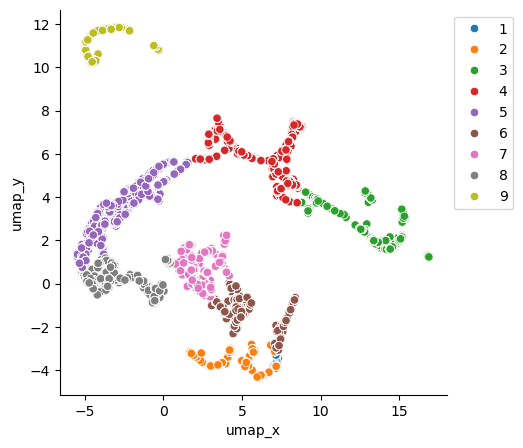

In [6]:
data = escape_matrix.copy()
cluster_to_plot = 'custom_cluster' # 'kmeans_cluster' # 'dbscan_cluster' # 
data.sort_values(cluster_to_plot, inplace=True)
data[cluster_to_plot] = data[cluster_to_plot].astype(str)
plt.figure(figsize=(5, 5))
sns.scatterplot(x='umap_x', y='umap_y', data=data, hue=cluster_to_plot)
plt.legend(bbox_to_anchor=(1,1))
sns.despine()
plt.show()

Plot each cluster of antibody-escape trajectories.

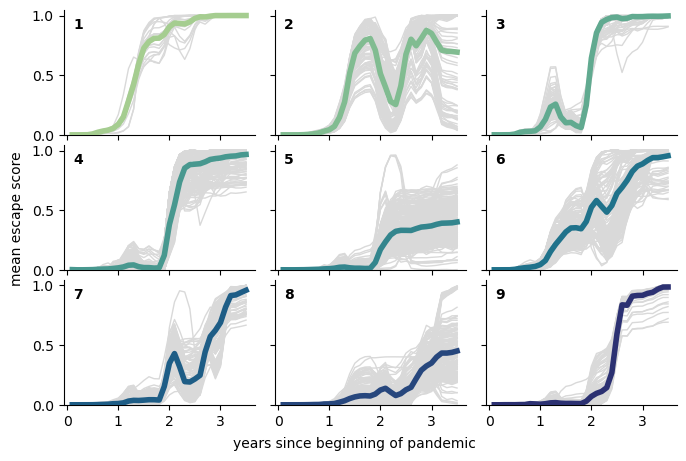

In [7]:
# Plot each antibody group's time series in its own facet
cluster_to_plot = 'custom_cluster' # 'kmeans_cluster' # 
data = (
    escape_matrix
    .groupby([cluster_to_plot, 'time']).mean(numeric_only=True).reset_index()
)
data.sort_values(cluster_to_plot, inplace=True)
g = sns.relplot(
    data=data,
    x="time", y="mean_escape", col=cluster_to_plot, hue=cluster_to_plot,
    kind="line", palette="crest", # 'husl', 
    linewidth=4, zorder=5,
    col_wrap=3, height=1.5, aspect=1.5,
    legend=False,
)

# Then plot other antibodies from group or other antibody groups in the background
groupby_cols = [
    'antibody',
    cluster_to_plot,
    'time'
]
for group, ax in g.axes_dict.items():
    if groupby_cols[0] == 'antibody':
        data = escape_matrix[
            escape_matrix[cluster_to_plot] == group
        ].groupby(groupby_cols).mean(numeric_only=True).reset_index()
    else:
        data = escape_matrix.groupby(groupby_cols).mean(numeric_only=True).reset_index()
    sns.lineplot(
        data=data, x="time", y="mean_escape", units=groupby_cols[0],
        estimator=None, color=".85", linewidth=1, ax=ax,
    )
    
    ax.set(yticks=[0,0.5,1], ylim=[0,1.05])
    ax.text(.05, .85, group, transform=ax.transAxes, fontweight="bold")

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "")
g.fig.text(0.5, -0.01, 'years since beginning of pandemic', ha='center')
g.fig.text(-0.01, 0.5, 'mean escape score', va='center', rotation='vertical')
g.tight_layout(h_pad=0.01)
plt.show()